### Get 5 minute data from IB
This requires you starting the IB History server. Use the following bash command:
1. cd ~/
2. bash launch_ibhist.sh
3. this command will navigate to /Dropbox/Jrtr/deployment_3_0/MeteorLaunch and launch another .sh file.



In [1]:
print(f'number of seconds in a day = {60*60000*24}')

number of seconds in a day = 86400000


In [2]:
import pandas as pd
import numpy as np
from dash.dependencies import Input, Output, State
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import datetime
from plotly.offline import  init_notebook_mode, iplot
init_notebook_mode(connected=True)
import os,sys
import importlib
import plot_utilities as pu
import math

Barchart OnDemand Client: https://marketdata.websol.barchart.com/
Barchart OnDemand Client: https://marketdata.websol.barchart.com/


## Set important parameters here.
### Reset ```REFETCH_IB``` to ```True``` if you want to re-fetch data from IB

In [3]:

REFETCH_IB = False
SAVE_BASE = !echo $(cd ~;pwd)
SAVE_BASE = f'{SAVE_BASE[0]}/dropbox/market_data/futures'
SAVE_BASE

'/Users/bperlman1/dropbox/market_data/futures'

### If REFETCH_IB == True, then fetch 5 minute bars from the IB History server that you ran from your console using the instructions above.

In [4]:
# fetch history from history server
def get_ib_futures_hist(contract,num_mins=5,days_to_fetch=120):
    n = datetime.datetime.now()    
    yyyy = n.year
    m = n.month
    t = datetime.datetime(yyyy,m,1)
    months_back = math.floor(max(0,(n-t).days/30))
    yyyymm_now = yyyy*100 + m
    parts = contract.split('.')
    yyyymm_contract = int(parts[4])
    mills = 60000 * num_mins
    h = f"http://127.0.0.1:8899/ibhistory?{mills}%20{days_to_fetch}%20{months_back}%20{num_mins}%20{contract}"
    print(h)
    df = pd.read_csv(h)
    return df


### Set the variables ```co``` and ```exch``` to a contract and exchange values like:
1. ZS and ECBOT, or 
2. CL and NYMEX

In [5]:
co = 'ZS'
exch = 'ECBOT'
yyyymms = [201801,201803,201805,201807,201808,201809,201811,201901,201903,201905,201907]
clist = [f'{co}.FUT.{exch}.USD.{yyyymm}' for yyyymm in yyyymms]
clist

['ZS.FUT.ECBOT.USD.201801',
 'ZS.FUT.ECBOT.USD.201803',
 'ZS.FUT.ECBOT.USD.201805',
 'ZS.FUT.ECBOT.USD.201807',
 'ZS.FUT.ECBOT.USD.201808',
 'ZS.FUT.ECBOT.USD.201809',
 'ZS.FUT.ECBOT.USD.201811',
 'ZS.FUT.ECBOT.USD.201901',
 'ZS.FUT.ECBOT.USD.201903',
 'ZS.FUT.ECBOT.USD.201905',
 'ZS.FUT.ECBOT.USD.201907']

In [6]:
if REFETCH_IB:
    dict_df = {}
    for c in clist:
        dict_df[c] = get_ib_futures_hist(c)
        dict_df[c].to_csv(f'{SAVE_BASE}/{co}/{c}.csv',index=False)


### Use the data to graph things of interest

In [7]:
fnames = sorted([fn for fn in os.listdir(f'{SAVE_BASE}/{co}') if co in f'{fn}.'])# 
fnames

['ZS.FUT.ECBOT.USD.201801.csv',
 'ZS.FUT.ECBOT.USD.201803.csv',
 'ZS.FUT.ECBOT.USD.201805.csv',
 'ZS.FUT.ECBOT.USD.201807.csv',
 'ZS.FUT.ECBOT.USD.201808.csv',
 'ZS.FUT.ECBOT.USD.201809.csv',
 'ZS.FUT.ECBOT.USD.201811.csv',
 'ZS.FUT.ECBOT.USD.201901.csv',
 'ZS.FUT.ECBOT.USD.201903.csv',
 'ZS.FUT.ECBOT.USD.201905.csv',
 'ZS.FUT.ECBOT.USD.201907.csv']

### Create  important date columns 
These columns help you scale the 5 minute bars to a longer minute length, like 15, 30 or 60 minutes, or one whole day

In [8]:
def get_date_cols(df,rts_end_hhmm):
    '''
    Create a new DataFrame with columns:
        year,month,day,hour,minute,dt,hhmm,isnextday,trade_date
    '''
    df2 = df.copy()
    df2['date_str'] =df2.date.astype(str)
    df2['year'] = df2.date_str.str.slice(0,4).astype(int) 
    df2['month'] = df2.date_str.str.slice(4,6).astype(int)  
    df2['day'] = df2.date_str.str.slice(6,8).astype(int)  
    df2['hour'] = df2.date_str.str.slice(8,10) .astype(int) 
    df2['minute'] = df2.date_str.str.slice(10,12) .astype(int)
    z = zip(df2.year,df2.month,df2.day,df2.hour,df2.minute)
    df2['dt'] = [datetime.datetime(x[0],x[1],x[2],x[3],x[4]) for x in z ]
    df2['hhmm'] = df2.date_str.str.slice(8,12)
    df2['isnextday'] = df2.hhmm > rts_end_hhmm
    z = zip(df2.dt,df2.isnextday.astype(int))
    df2['trade_date'] = [x[0] + datetime.timedelta(x[1]) for x in z]
    df2.trade_date = df2.trade_date.astype(str).str.replace('-','').str.slice(0,8)
    return df2

### Define a method to rescale csv files for a specific commodity's from 5 minute data to a "less granular" bar size, like 30 minute bars.

In [9]:
def scale_intraday(df,minute_scale,end_hhmm='1430'):
    scale_functions = {'adjusted':'last','close':'last', 'high':'max','low':'min', 
                       'open':'first', 'volume':'sum','execute_date':'first'}    

    df2 = df.copy()
    df3 = get_date_cols(df2,end_hhmm)
    def _get_hhmm_rescaled(hhmm,minute_scale):
        p1 = str(hhmm)[:2]
        p2 = int(str(hhmm)[-2:])
        p2 = int(p2/minute_scale) * minute_scale
        p2 = '%02d'%(p2)
        p = p1+p2
        return int(p)

    df3['hhmm_rescaled'] = ['%04d' %(_get_hhmm_rescaled(s,30)) for s in df3.hhmm]
    df3['execute_date'] = df3.date.astype(str).str.slice(0,8)
    df4 = df3[['trade_date','hhmm_rescaled','execute_date','shortName','open','high','low','close','volume','adjusted']]
    df4_scaled = df4.groupby(['trade_date','hhmm_rescaled'],as_index=False).agg(scale_functions)
    df4_scaled['date'] = df4_scaled.execute_date + df4_scaled.hhmm_rescaled + '00'
    df4_scaled = df4_scaled.sort_values('date')
    df5_scaled = get_date_cols(df4_scaled,end_hhmm)
    df5_scaled
    return df5_scaled


### Define a method to rescale 5 minute bars to daily bars

In [10]:
def scale_daily(df,hhmm_for_open):
    scale_functions = {'adjusted':'last','close':'last', 'high':'max','low':'min', 
                       'daily_open':'mean', 'volume':'sum'}    
    df2 = get_date_cols(df,'1430')
    df2_open = df2[df2.hhmm==hhmm_for_open][['trade_date','open']]
    df2_open = df2_open.rename(columns={'open':'daily_open'})
    df3 = df2.merge(df2_open,how='inner',on='trade_date')
    df3 = df3[['trade_date','shortName','daily_open','high','low','close','volume','adjusted']]
    df4_scaled = df3.groupby('trade_date',as_index=False).agg(scale_functions)
    df4_scaled['date'] = [int(s  + '000000') for s in df4_scaled.trade_date.astype(str)]
    df4_scaled = df4_scaled.rename(columns={'daily_open':'open'})
    df4_scaled = get_date_cols(df4_scaled,'1430')
    return df4_scaled

### Compare daily and intra day data
Loop through sets of days for a specific contract, and print:
1. The daily bars
2. The intraday bars

<Figure size 432x288 with 0 Axes>

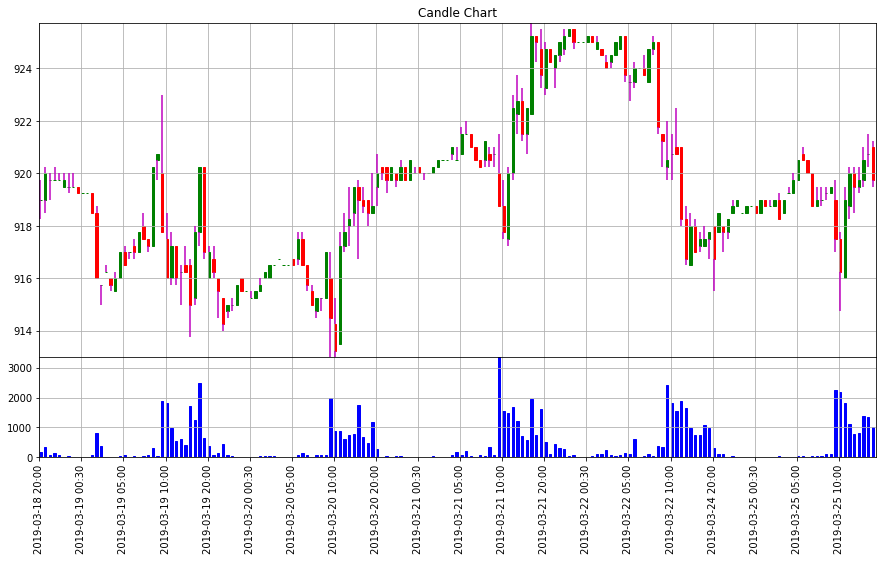

<Figure size 432x288 with 0 Axes>

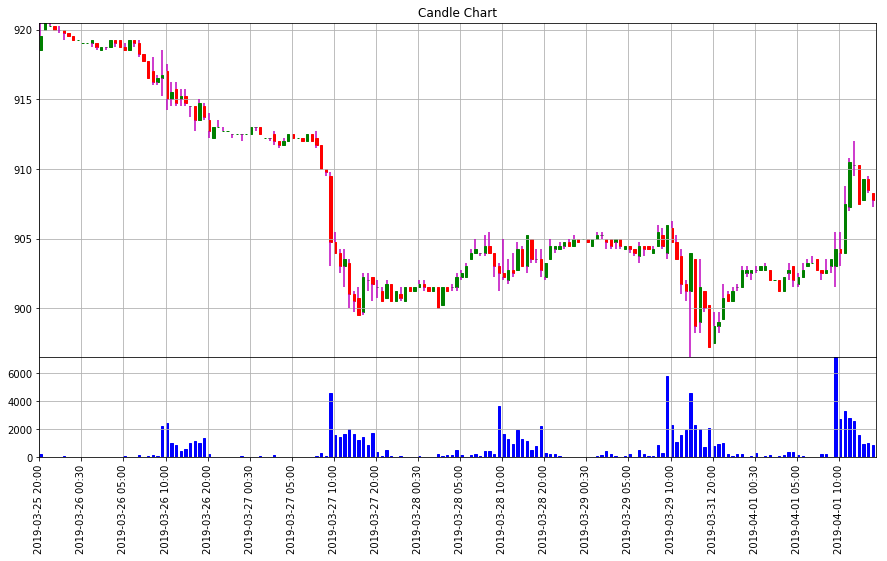

<Figure size 432x288 with 0 Axes>

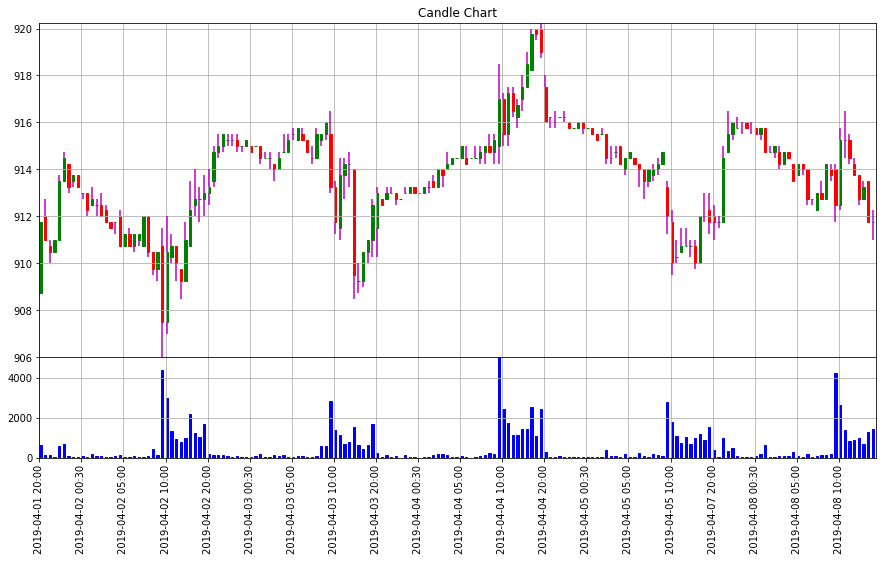

<Figure size 432x288 with 0 Axes>

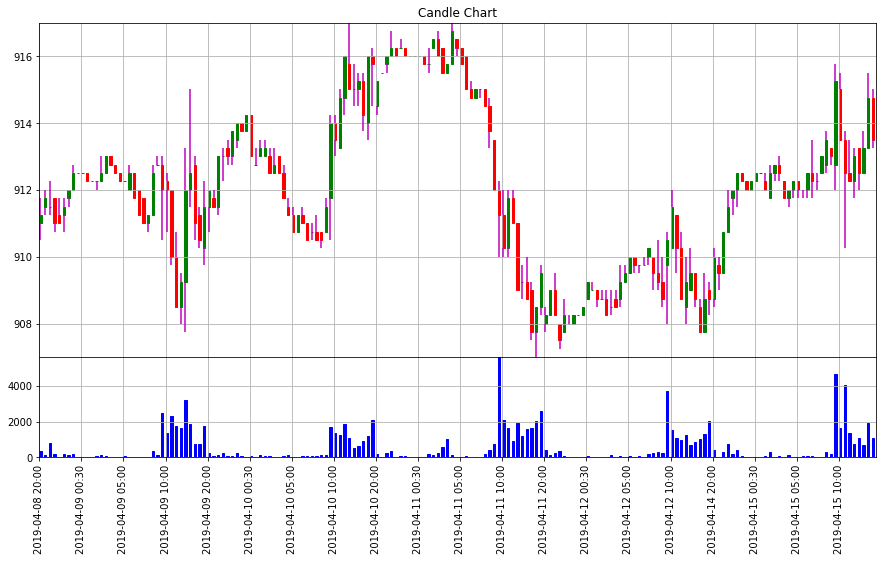

<Figure size 432x288 with 0 Axes>

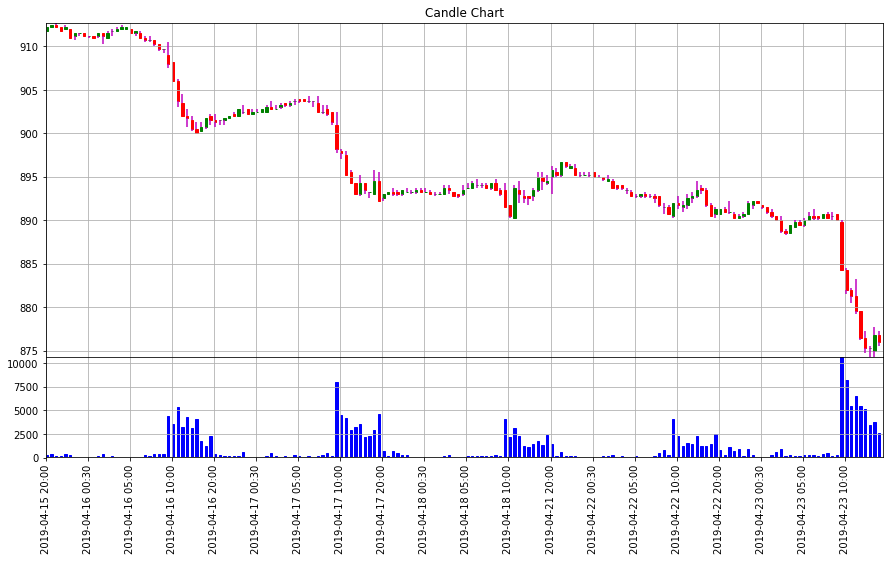

<Figure size 432x288 with 0 Axes>

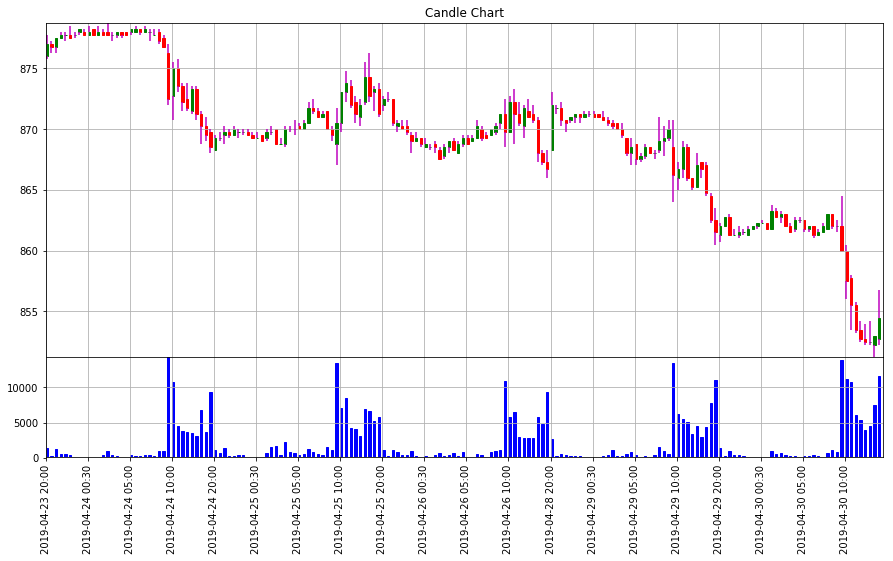

<Figure size 432x288 with 0 Axes>

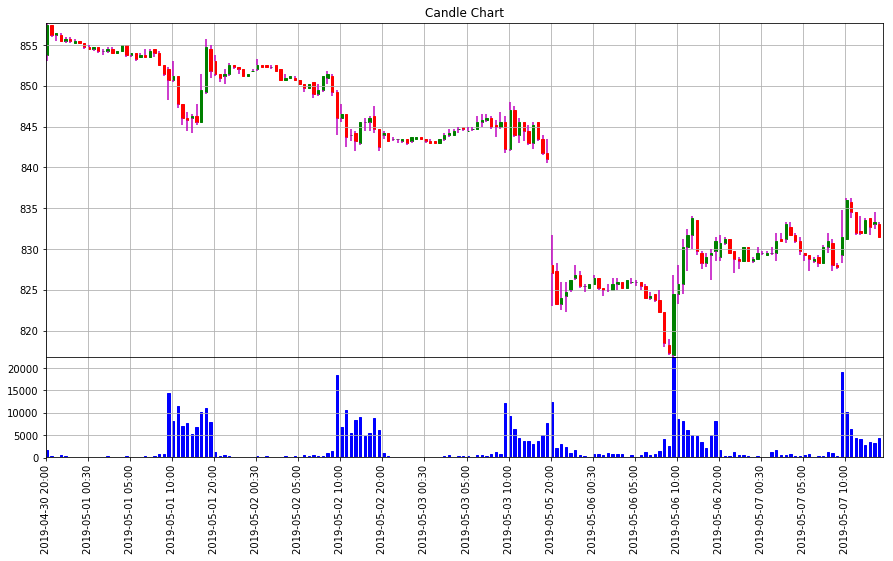

<Figure size 432x288 with 0 Axes>

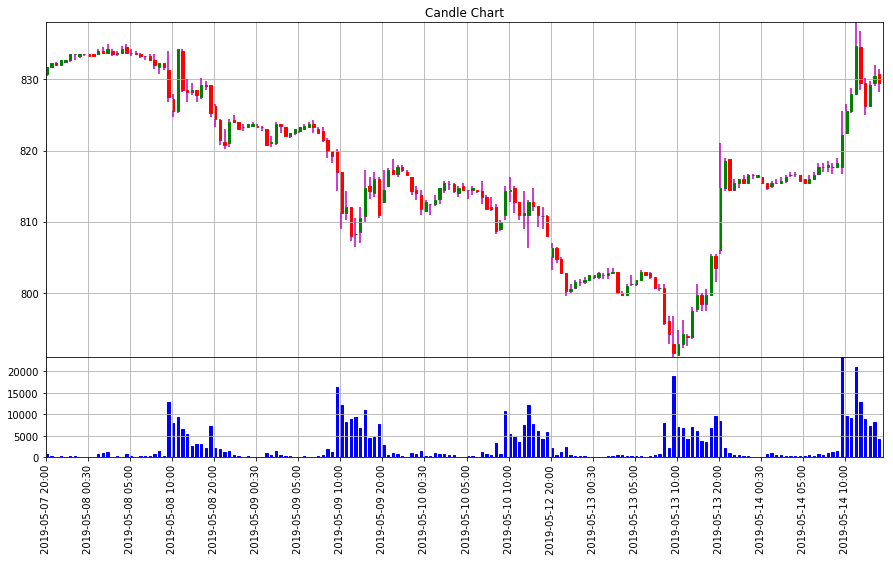

<Figure size 432x288 with 0 Axes>

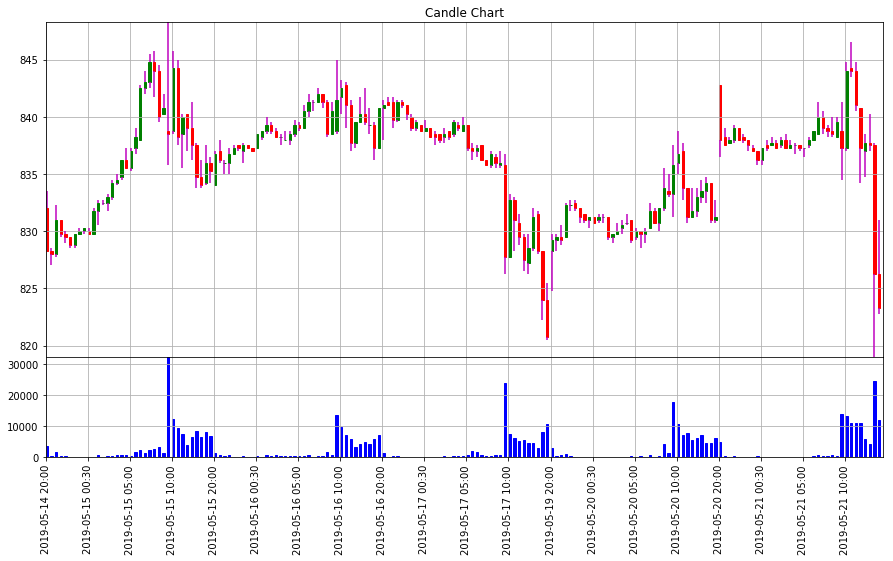

In [12]:
from itertools import groupby
# set the number of daily days to print on each iteration
days_to_print=5

def divby(val):
    return math.floor(val/days_to_print)

df = pd.read_csv(f'{SAVE_BASE}/{co}/{fnames[-1]}')
df_rescaled_daily = scale_daily(df=df,hhmm_for_open='0930')
all_days_indice_groups = [list(it) for k, it in groupby(list(range(len(df_rescaled_daily))), divby)] 
df_rescaled_intra = scale_intraday(df,minute_scale=30)
# pu.candles(date_column='dt',df=df_rescaled_daily,date_offset_to_show=(0,10),title=fname)
for ad in all_days_indice_groups:
    tds = df_rescaled_daily.iloc[ad].trade_date.values
    df_rescaled_daily_partial = df_rescaled_daily[df_rescaled_daily.trade_date.isin(tds)]
    try:
        pu.candles(date_column='dt',df=df_rescaled_daily_partial,date_offset_to_show=(0,10),title=fname)
    except:
        pass
    plt.figure()
    df_rescaled_intra_partial = df_rescaled_intra[df_rescaled_intra.trade_date.isin(tds)]
    pu.candles(date_column='dt',df=df_rescaled_intra_partial,date_offset_to_show=(0,16))
                                                  
                                                  
                                                  

### Print daily data for all contracts of commodities in fnames

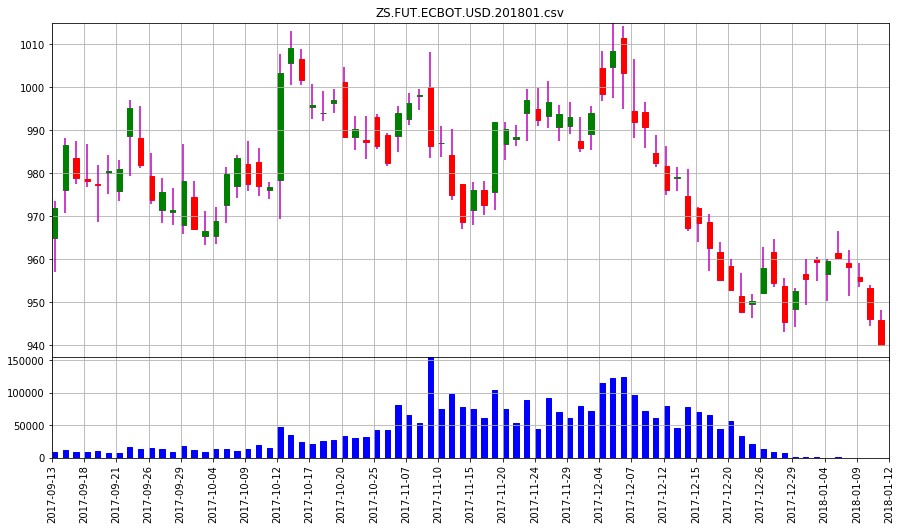

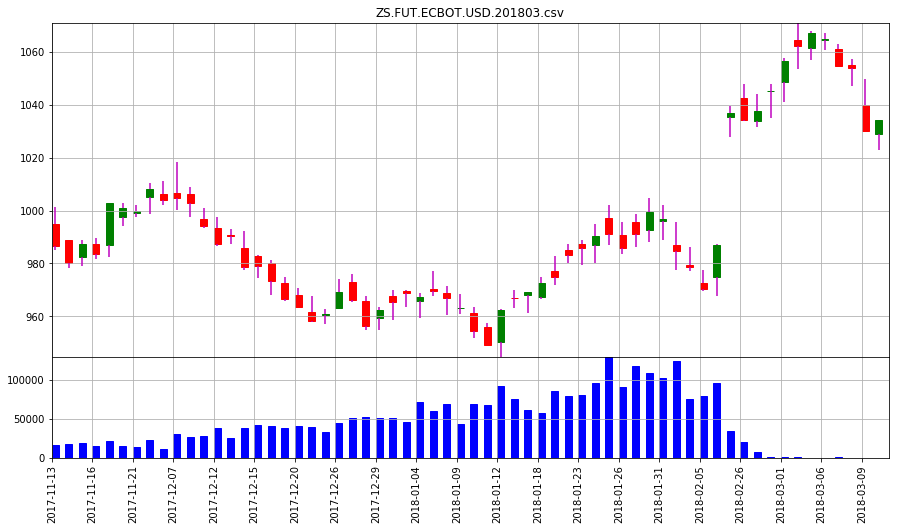

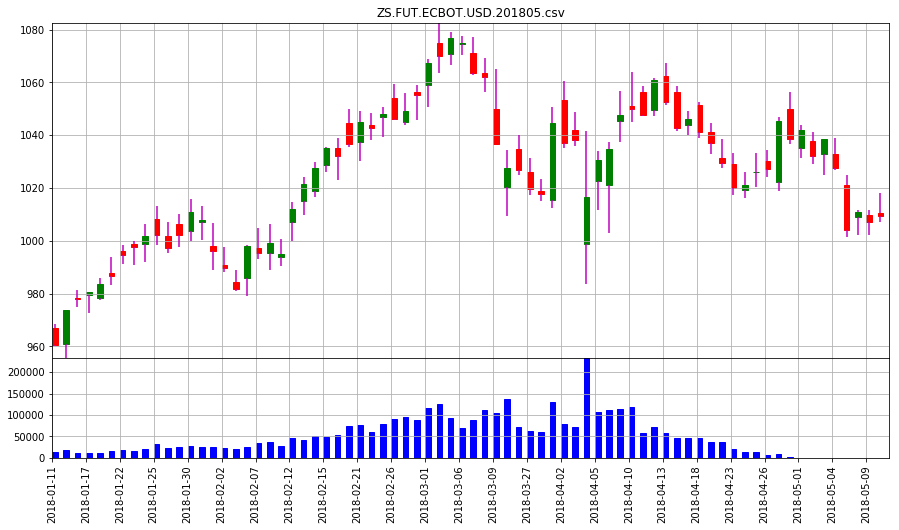

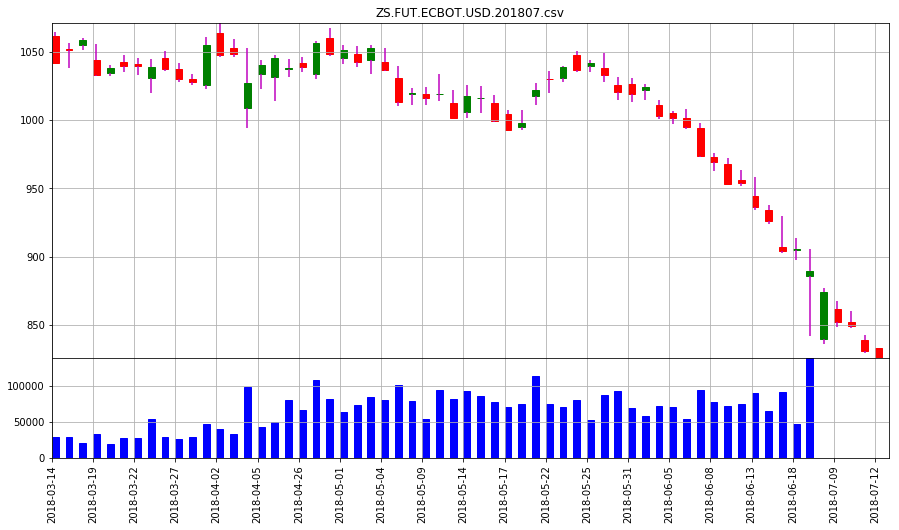

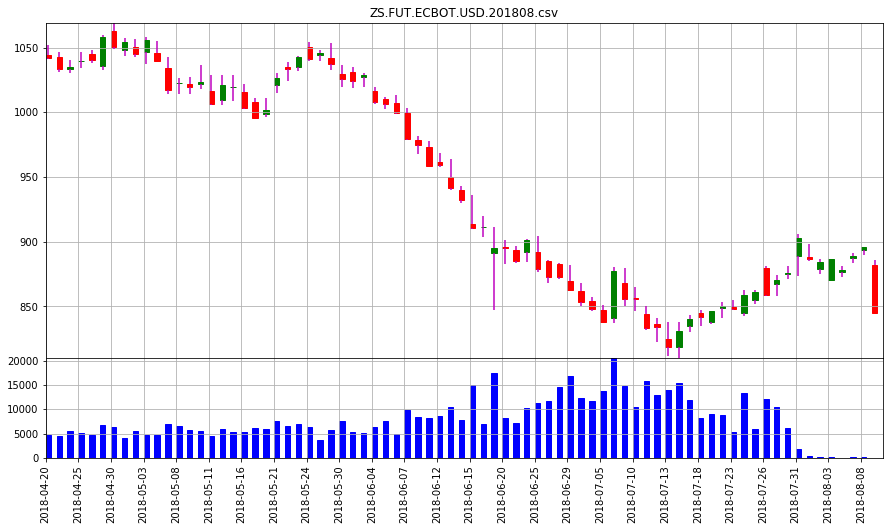

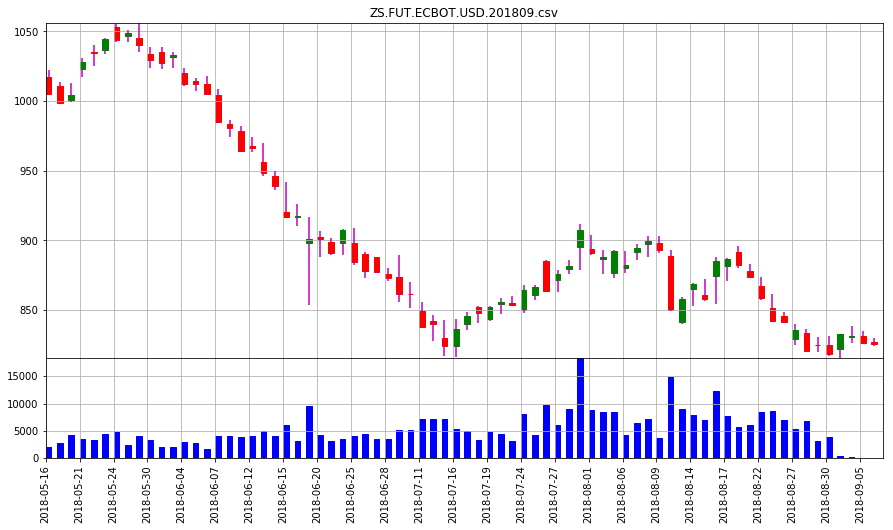

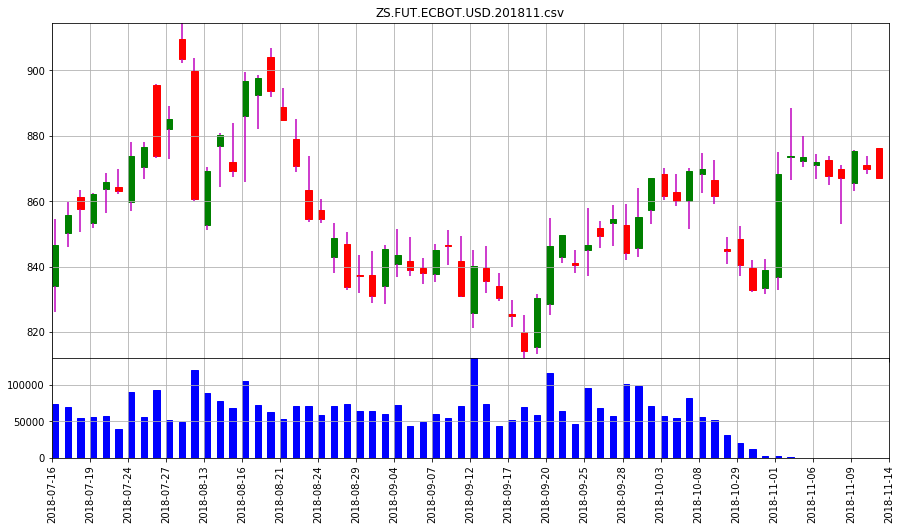

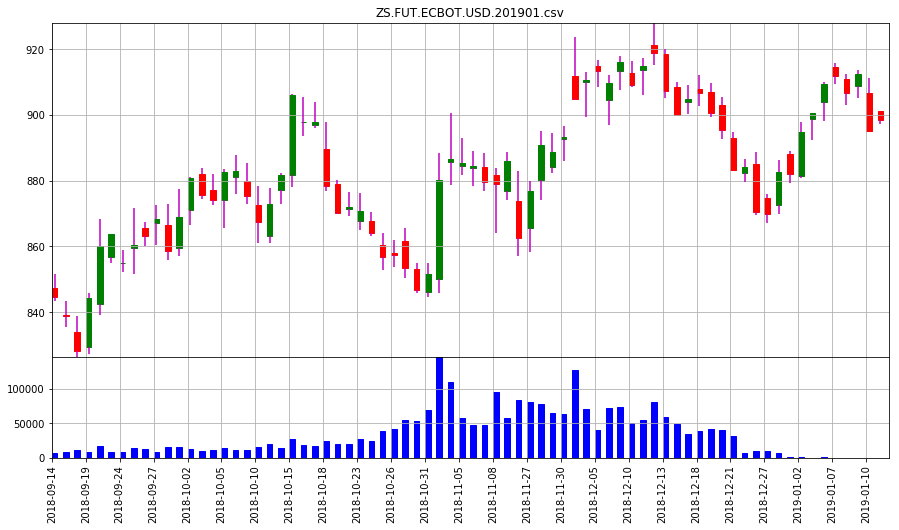

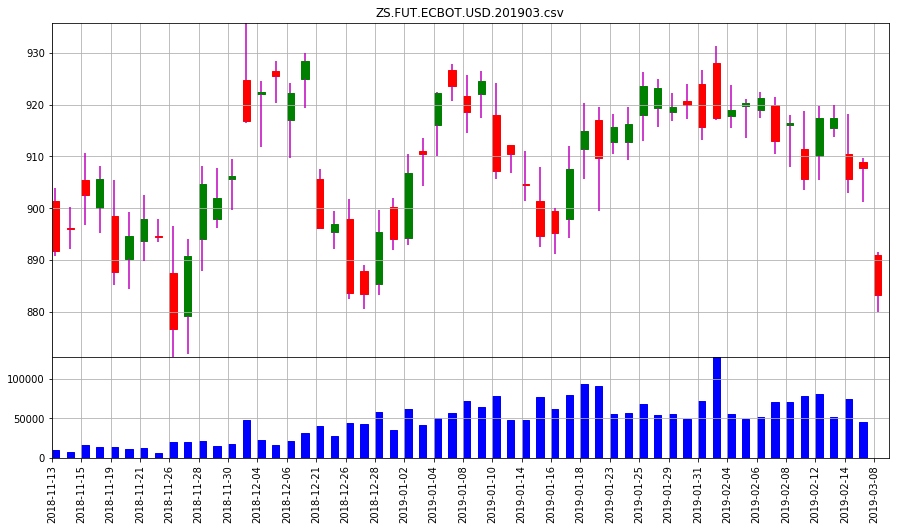

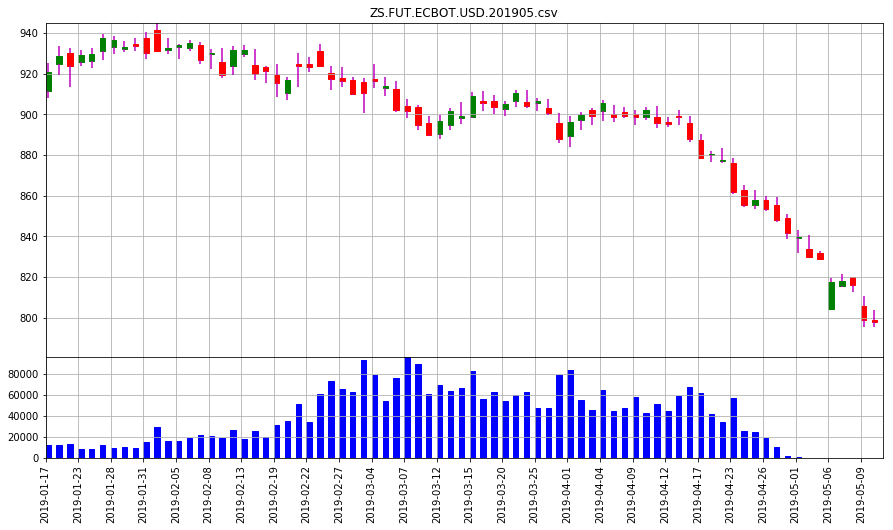

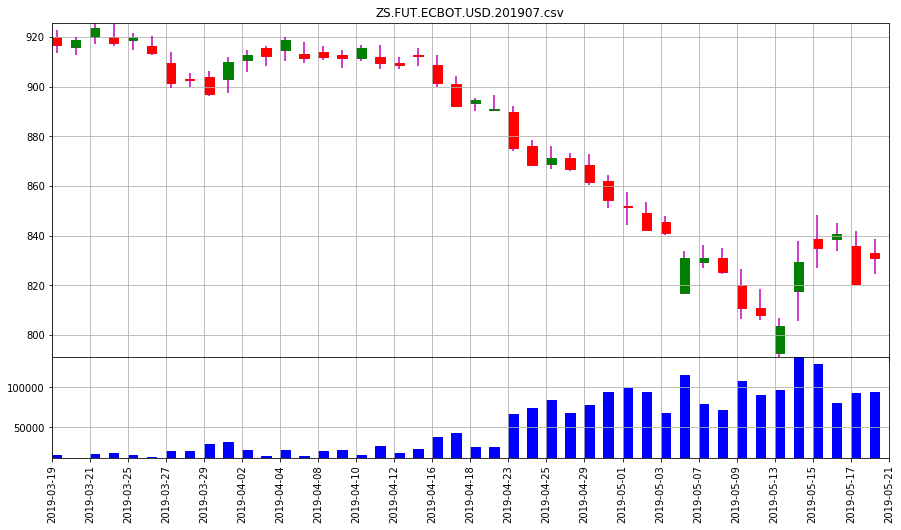

In [13]:
for fname in fnames:
    df = pd.read_csv(f'{SAVE_BASE}/{co}/{fname}')
    df_rescaled_daily = scale_daily(df,'0930')
    pu.candles(date_column='dt',df=df_rescaled_daily,date_offset_to_show=(0,10),title=fname)
#     all_days = df_rescaled_daily.dt
#     all_days_indice_groups = [list(it) for k, it in groupby(list(range(len(all_days))), divby)] 
#     df_rescaled_intra = scale_intraday(df,minute_scale=30)
#     pu.candles(date_column='dt',df=df_rescaled_intra,date_offset_to_show=(0,16))
    

### Show bar graph of daily % changes, and a moving average of them as well

In [14]:

for fname in fnames:
    df = pd.read_csv(f'{SAVE_BASE}/{co}/{fname}')
    df_rescaled_daily = scale_daily(df,'0930')
    df_rescaled_daily['chg'] = df_rescaled_daily.close.pct_change()
    df_rescaled_daily['roll_mean'] = df_rescaled_daily.chg.rolling(5).mean()
    iplot(pu.plotly_bar_plot(df_in=df_rescaled_daily[['dt','chg','roll_mean']],x_column='dt',plot_title=fname))


In [15]:
for fname in fnames:
    df = pd.read_csv(f'{SAVE_BASE}/{co}/{fname}')
    df_rescaled_daily = scale_daily(df,'0930')
    df_rescaled_daily.date = df_rescaled_daily.date.apply(lambda s:f'{str(s)[0:4]}-{str(s)[4:6]}-{str(s)[6:8]}')
    fig = pu.plotly_candles(df_rescaled_daily,number_of_ticks_display=21,title=fname.replace('.csv',''))



In [38]:
SAVE_BASE

'/Users/bperlman1/dropbox/market_data/futures'

In [39]:
REFETCH_IB_DAILY=True
import traceback
contract='ZS'
short_names = [f'{contract}.FUT.ECBOT.USD.2018{m}' for m in ['01','03','05','07','08','09','11']]
short_names += [f'{contract}.FUT.ECBOT.USD.2019{m}' for m in ['01','03','05','07']]
SAVE_BASE_DAILY = f'{SAVE_BASE}/{contract}/daily'
if REFETCH_IB_DAILY:
    if not os.path.isdir(os.path.abspath(SAVE_BASE_DAILY)):
        os.mkdir(SAVE_BASE_DAILY)
    dict_df2 = {}
    for short_name in short_names:
        try:
            print(short_name)
            dict_df2[short_name] = get_ib_futures_hist(short_name,num_mins=60*24,days_to_fetch=120)
        except Exception as e:
            print(str(e))
            traceback.print_exc()
    for sn in dict_df2.keys():
        sn_csv = sn.replace('.','_')
        dict_df2[sn].to_csv(f'{SAVE_BASE_DAILY}/{sn_csv}.csv')

ZS.FUT.ECBOT.USD.201801
http://127.0.0.1:8899/ibhistory?86400000%20120%200%201440%20ZS.FUT.ECBOT.USD.201801
ZS.FUT.ECBOT.USD.201803
http://127.0.0.1:8899/ibhistory?86400000%20120%200%201440%20ZS.FUT.ECBOT.USD.201803
ZS.FUT.ECBOT.USD.201805
http://127.0.0.1:8899/ibhistory?86400000%20120%200%201440%20ZS.FUT.ECBOT.USD.201805
ZS.FUT.ECBOT.USD.201807
http://127.0.0.1:8899/ibhistory?86400000%20120%200%201440%20ZS.FUT.ECBOT.USD.201807
ZS.FUT.ECBOT.USD.201808
http://127.0.0.1:8899/ibhistory?86400000%20120%200%201440%20ZS.FUT.ECBOT.USD.201808
ZS.FUT.ECBOT.USD.201809
http://127.0.0.1:8899/ibhistory?86400000%20120%200%201440%20ZS.FUT.ECBOT.USD.201809
ZS.FUT.ECBOT.USD.201811
http://127.0.0.1:8899/ibhistory?86400000%20120%200%201440%20ZS.FUT.ECBOT.USD.201811
ZS.FUT.ECBOT.USD.201901
http://127.0.0.1:8899/ibhistory?86400000%20120%200%201440%20ZS.FUT.ECBOT.USD.201901
ZS.FUT.ECBOT.USD.201903
http://127.0.0.1:8899/ibhistory?86400000%20120%200%201440%20ZS.FUT.ECBOT.USD.201903
ZS.FUT.ECBOT.USD.201905
http

In [40]:
dict_df2 = {}
daily_files = sorted([str(s) for s in os.listdir(SAVE_BASE_DAILY) if ".csv" in s])
for fn in daily_files:
    sn = fn.replace('_','.').replace('.csv','')
    dict_df2[sn] = pd.read_csv(f'{SAVE_BASE_DAILY}/{fn}')
        

In [86]:
def normalize_by_std(df,cutoff_perc,volume_threshold,open_col='open'):
    df_ret = df.copy()
    df_ret['prev_close'] = df_ret.close.shift(1)
    df_ret = df_ret[df_ret.volume>=volume_threshold]
    df_ret.close = df_ret.apply(lambda r: min(r.close/r[open_col] - 1,cutoff_perc),axis=1)
    df_ret.high = df_ret.apply(lambda r: min(r.high/r[open_col] - 1,cutoff_perc),axis=1)
    df_ret.low = df_ret.apply(lambda r: max(r.low/r[open_col] - 1,-1*cutoff_perc),axis=1)
    df_ret.open = 0
#     df_ret['direction'] = df_ret.high > df_ret.low*-1
#     df_ret.direction = df_ret.direction.apply(lambda t: 1 if t else -1)
#     df_ret['prev_direction'] = df_ret.direction.shift(1)
#     df_ret['trend'] = abs(df_ret.direction + df_ret.prev_direction)/2
#     df_ret = df_ret[~df_ret.trend.isnull()]
#     df_ret[df_ret.trend==0] = -1
    return df_ret

In [110]:
def conseq_chgs(df,cutoff_perc,volume_threshold,open_col='open'):
    df_ret = normalize_by_std(df,cutoff_perc,volume_threshold,open_col=open_col)
    df_ret['prev_chg'] = df_ret.close.shift(1)
    df_ret['direction_has_changed'] = df_ret.close * df_ret.prev_chg < 0
    return df_ret

for sn in dict_df2.keys():
    df_test = dict_df2[sn]
    df_test.index = list(range(len(df_test)))
    df_test2 = conseq_chgs(df_test,.9,30000)[['direction_has_changed']]
    c = df_test2[df_test2.direction_has_changed].index[1:] - df_test2[df_test2.direction_has_changed].index[:-1]
    c = np.array(c[1:])
    print(sn,len(c[c>1])/len(c))


ZS.FUT.ECBOT.USD.201801 0.3181818181818182
ZS.FUT.ECBOT.USD.201803 0.4
ZS.FUT.ECBOT.USD.201805 0.37037037037037035
ZS.FUT.ECBOT.USD.201807 0.4


ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [93]:
s = list(dict_df2.keys())[1]
df_test = dict_df2[s].copy()
df_test.index = list(range(len(df_test)))
df_test = normalize_by_std(df_test,.9,30000)
df_test.date = df_test.date.astype(str).str.slice(0,10)

f = pu.plotly_candles(df_test,number_of_ticks_display=21,title=s)


In [69]:
# df_bc_zsh19 = pu.get_barchart_daily('ZSH19',days_to_fetch=120)
# df_bc_zsh19.date = [str(d)[0:10] for d in df_bc_zsh19.date]
df_ib_zsh19 = dict_df2['ZS.FUT.ECBOT.USD.201903'].iloc[-32:]
f = pu.plotly_candles(df=df_bc_zsh19,number_of_ticks_display=21,title='bc')
f = pu.plotly_candles(df=df_ib_zsh19,number_of_ticks_display=21,title='ib')

[ 6 16 32 40 60 71 85 98]


ZS.FUT.ECBOT.USD.201805 error - slice step cannot be zero


ZS.FUT.ECBOT.USD.201901 error - slice step cannot be zero


ZS.FUT.ECBOT.USD.201905 error - slice step cannot be zero


ZS.FUT.ECBOT.USD.201907 error - index 71 is out of bounds for axis 0 with size 70
ZS.FUT.ECBOT.USD.201907 error - index 85 is out of bounds for axis 0 with size 70
ZS.FUT.ECBOT.USD.201907 error - index 98 is out of bounds for axis 0 with size 70
[20171228 20180112 20180206 20180216 20180319 20180404 20180424 20180511]


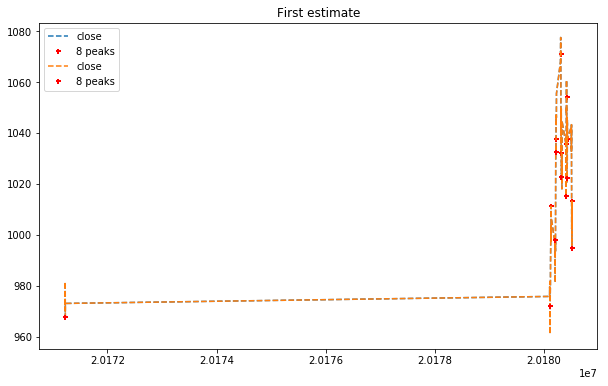

In [80]:
import peakutils
from peakutils.plot import plot as pplot
x = df_test.date.values

# get Peaks
y = df_test.high.values
high_indexes = peakutils.indexes(y, thres=0.3, min_dist=7)
# print(high_indexes)
# print(x[high_indexes], y[high_indexes])
plt.figure(figsize=(10,6))

# get Valleys
y = df_test.low.values * -1
low_indexes = peakutils.indexes(y, thres=0.3, min_dist=7)
print(low_indexes)
y = df_test.close
pplot(x, y, high_indexes)
pplot(x, y, low_indexes)

plt.title('First estimate')
for sn in dict_df2.keys():
    df_test = dict_df2[sn]
    for i in low_indexes:
        try:
            f = pu.plotly_candles(df=df_test.iloc[i-3:i+3],number_of_ticks_display=6,title=f'{sn} - {df_test.date.values[i]}')
        except Exception as e:
            print(f'{sn} error - {str(e)}')
print(x[low_indexes])


In [623]:
co = .05
vt = 30000
syms = []
up_counts = []
down_counts = []
for s in dict_df2.keys():
    df = normalize_by_std(dict_df2[s],co,vt)
    df.date = df.date.astype(str).str.slice(0,10)
    fig = pu.plotly_candles(df,number_of_ticks_display=21,title=s)
    syms.append(s)
    up_counts.append(len(df[df.high>-1*df.low]))
    down_counts.append(len(df[df.high<-1*df.low]))
print(pd.DataFrame({'sym':syms,'upc':up_counts,'dnc':down_counts}))

    dnc                      sym  upc
0    32  ZS.FUT.ECBOT.USD.201801   13
1    37  ZS.FUT.ECBOT.USD.201803   14
2    32  ZS.FUT.ECBOT.USD.201805   18
3    48  ZS.FUT.ECBOT.USD.201807   16
4    80  ZS.FUT.ECBOT.USD.201808   20
5    85  ZS.FUT.ECBOT.USD.201809   16
6    72  ZS.FUT.ECBOT.USD.201811   17
7    28  ZS.FUT.ECBOT.USD.201901   11
8    32  ZS.FUT.ECBOT.USD.201903   11
9    37  ZS.FUT.ECBOT.USD.201905    7
10   24  ZS.FUT.ECBOT.USD.201907    3


In [618]:
co = .005
vt = 30000
syms = []
up_counts = []
down_counts = []
t = 0
for s in dict_df2.keys():
    df = normalize_by_std(dict_df2[s],co,vt)
    v = df.trend.sum()
    t += v
    print(f'{s}: {v}')
print(f'total: {t}')

ZS.FUT.ECBOT.USD.201801: -7.0
ZS.FUT.ECBOT.USD.201803: 3.0
ZS.FUT.ECBOT.USD.201805: 4.0
ZS.FUT.ECBOT.USD.201807: 12.0
ZS.FUT.ECBOT.USD.201808: 14.0
ZS.FUT.ECBOT.USD.201809: 15.0
ZS.FUT.ECBOT.USD.201811: 3.0
ZS.FUT.ECBOT.USD.201901: -5.0
ZS.FUT.ECBOT.USD.201903: -10.0
ZS.FUT.ECBOT.USD.201905: -12.0
ZS.FUT.ECBOT.USD.201907: -5.0
total: 12.0


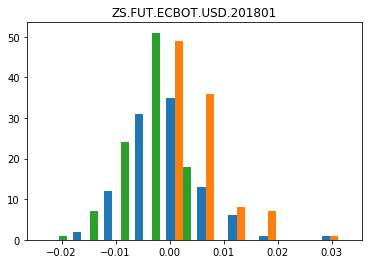

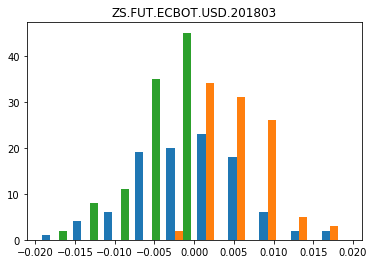

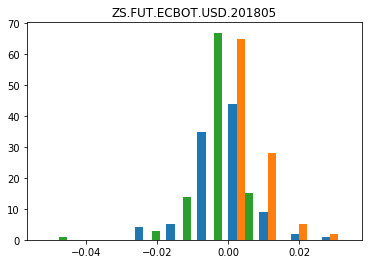

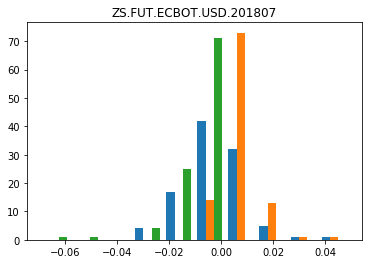

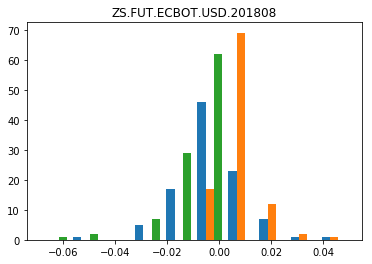

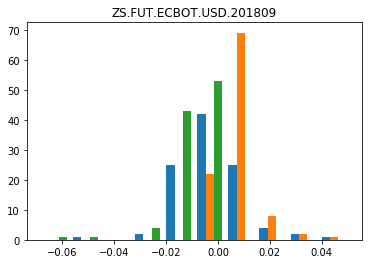

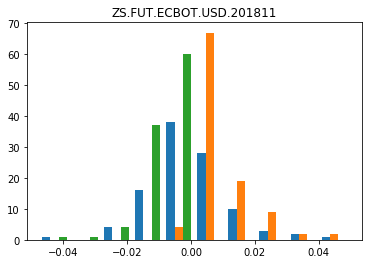

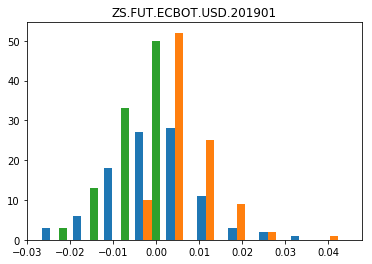

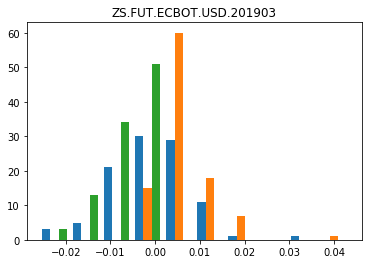

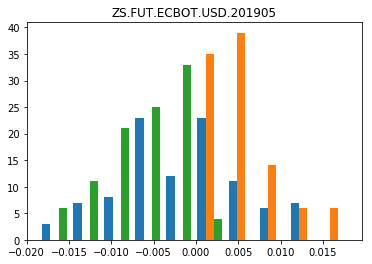

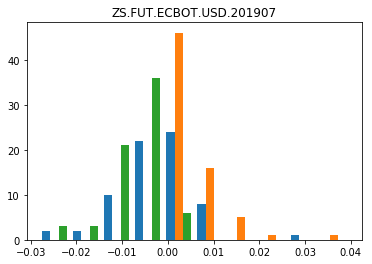

In [564]:

for s in dict_df2.keys():
    df = normalize_by_std(dict_df2[s])
#     data = [
#         go.Histogram(x=[df.close.values],nbinsx=50),
#         go.Histogram(x=[df.high.values],nbinsx=50)
#     ]
#     fig = go.Figure(data)
#     iplot(fig)
    fig = plt.figure()
    plt.title(s)
    plt.hist([df.close.values,df.high.values,df.low.values])
